## Lec 9. Transformer

- 神经网络结构
    - DNN 线性神经网络
    - CNN 卷积神经网络
    - RNN 循环神经网络
    - Transformer 神经网络结构 [2017.]  word2vec
        - Encoder-Decoder (GLM)
        - Encoder-Only (BERT)
        - Decoder-Only (GPT, Llama)
------     
- Pretrain Model 预训练模型
- Emergent Abilities 涌现能力
- Scaling Law 尺度定律
- Token
------
- Large Language Model 大语言模型
    - RNN Base
    - Transformer Base
    - RWKV (RNN + Transformer)
    - Mamba (SSM -> HiPPO -> S4 -> Mamba)


### 9.1 Attention 注意力机制
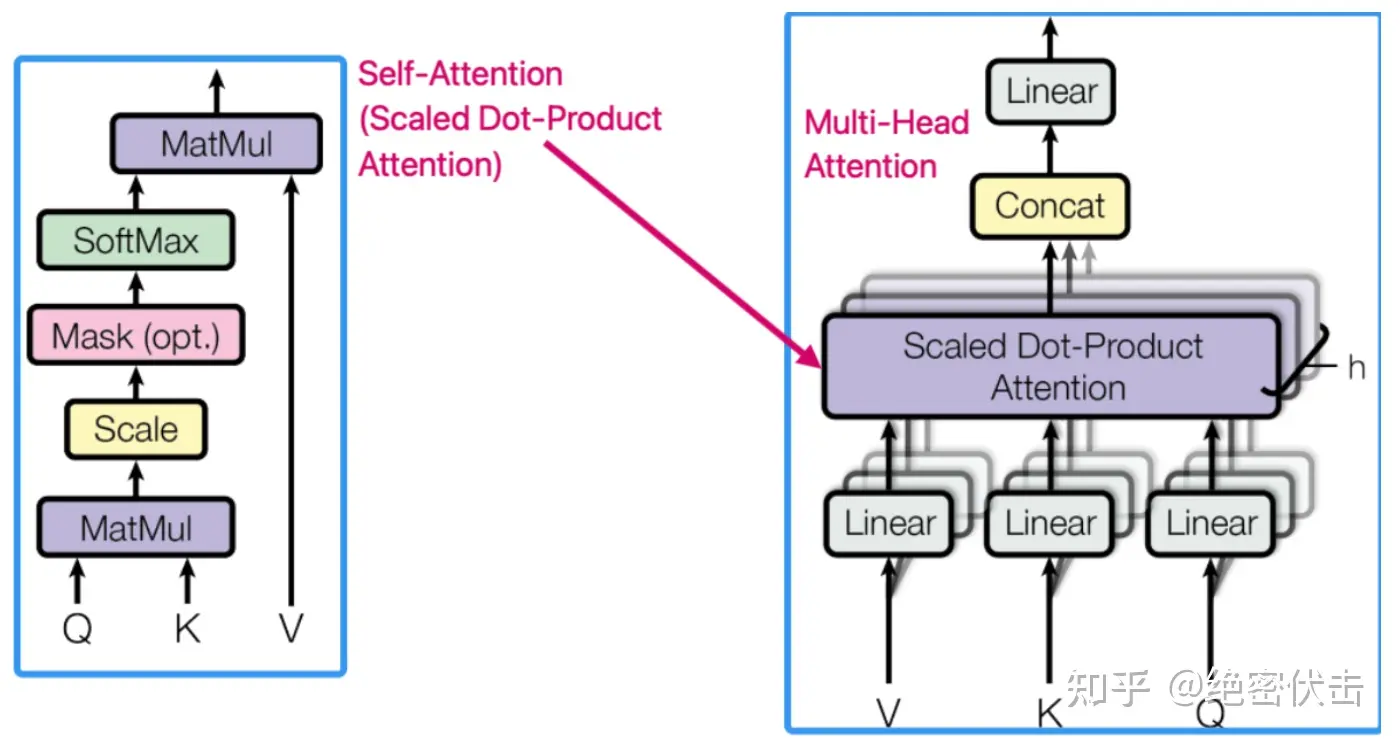

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

In [2]:
batch_size = 16
seq_len = 20
embedding_size = 1024
hidden_size = 2048

n_head = 4

In [3]:
embedded = torch.randn(batch_size, seq_len, embedding_size)
positional_encoding = torch.randn(batch_size, seq_len, embedding_size)

embedded = embedded + positional_encoding
embedded.shape

torch.Size([16, 20, 1024])

In [7]:
class ScaledDotProductAttention(nn.Module):
    """ 注意力计算单元 """
    def __init__(self):
        super().__init__()

    def forward(self, q, k, v, d_k):
        """ 前向传播方法 """
        # q, k, v: [batch_size, seq_len, hidden_size]
        diff = torch.abs(q.unsqueeze(3) - k.unsqueeze(2))
        max_distance = torch.amax(diff,dim=-1)
        attn = max_distance/ torch.sqrt(torch.tensor(d_k))
        output = torch.matmul(attn, v) # output: [batch_size, seq_len, hidden_size]
        return output, attn

class MultiHeadAttention(nn.Module):
    """ 多头注意力网络 """
    def __init__(self, embedding_size, hidden_size, n_heads=4):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = hidden_size // n_heads
        
        self.key = nn.Linear(embedding_size, hidden_size)
        self.query = nn.Linear(embedding_size, hidden_size)
        self.value = nn.Linear(embedding_size, hidden_size)
        self.fc = nn.Linear(hidden_size, embedding_size)

    def forward(self, input_k, input_q, input_v):
        """ 前向传播方法 """
        # input_k, input_q, input_v: [batch_size, seq_len, embedding_size]
        # k, q, v: [batch_size, seq_len, hidden_size]
        # k, q, v: [batch_size, seq_len, n_heads, d_k] -> [batch_size, n_heads, seq_len, d_k]
        k = self.key(input_k).view(input_k.size(0), input_k.size(1), self.n_heads, self.d_k).transpose(1, 2)
        q = self.query(input_q).view(input_q.size(0), input_q.size(1), self.n_heads, self.d_k).transpose(1, 2)
        v = self.value(input_v).view(input_v.size(0), input_v.size(1), self.n_heads, self.d_k).transpose(1, 2)

        output, attn = ScaledDotProductAttention()(q, k, v, self.d_k)
        # output: [batch_size, n_heads, seq_len, d_k] ->
        # output: [batch_size, seq_len, n_heads, d_k] -> [batch_size, seq_len, hidden_size]
        output = output.transpose(1, 2).reshape(input_q.size(0), input_q.size(1), -1)
        return self.fc(output), attn

In [8]:
model = MultiHeadAttention(embedding_size, hidden_size)
model

MultiHeadAttention(
  (key): Linear(in_features=1024, out_features=2048, bias=True)
  (query): Linear(in_features=1024, out_features=2048, bias=True)
  (value): Linear(in_features=1024, out_features=2048, bias=True)
  (fc): Linear(in_features=2048, out_features=1024, bias=True)
)

In [9]:
output, attn = model(embedded, embedded, embedded)
output = output + embedded  # 残差

output.shape, attn.shape

(torch.Size([16, 20, 1024]), torch.Size([16, 4, 20, 20]))

In [ ]:
model.key.weight.shape

### 9.2 Transformer模型
Transformer 架构
- [x] Encoder-Decoder 结构
- [x] Embedding 嵌入层
- [x] Positional Encoding 位置编码
- Transformer Encoder / Decoder Layer:
    - [x] Multi-Head Attention 多头注意力层
    - [x] Add & Norm 残差 & 批归一化
    - [x] Feed Forward 前馈神经网络

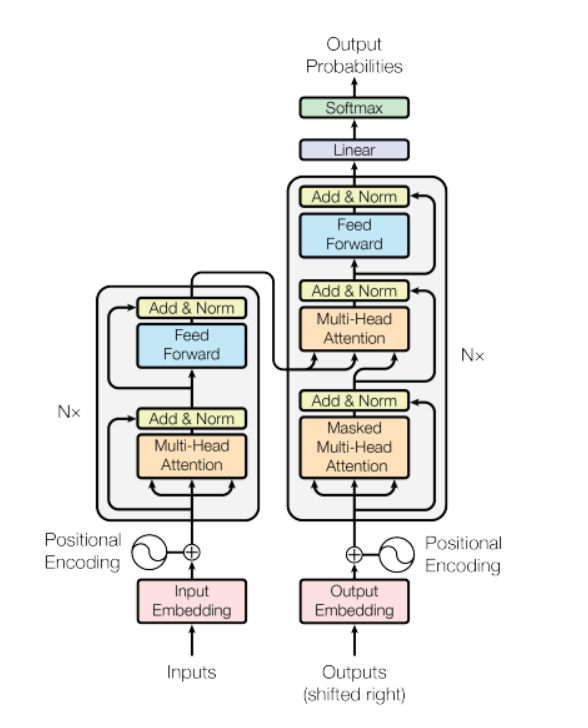

In [ ]:
class PositionalEncoding(nn.Module):
    """ 位置编码 """
    def __init__(self, embedding_size, dropout=0.1, max_length=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pos_table = np.array([
            [pos / np.power(10000, 2 * i / embedding_size) for i in range(embedding_size)]
            if pos != 0 else np.zeros(embedding_size) for pos in range(max_length)])
        # 偶数位置编码
        pos_table[1:, 0::2] = np.sin(pos_table[1:, 0::2])
        # 奇数位置编码
        pos_table[1:, 1::2] = np.cos(pos_table[1:, 1::2])

        self.pos_table = torch.FloatTensor(pos_table)

    def forward(self, embedded_input):
        """ 前向传播方法 """
        # embedded_input: [batch_size, seq_len, embedding_size]
        embedded_input = embedded_input + self.pos_table[: embedded_input.size(1), :]
        return self.dropout(embedded_input)

class FeedForward(nn.Module):
    """ 前馈神经网络 """
    def __init__(self, embedding_size, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, embedding_size)
        self.norm = nn.LayerNorm(embedding_size)

    def forward(self, x):
        # x: [batch_size, seq_len, embedding_size]
        hidden = self.relu(self.fc1(x)) # hidden: [batch_size, seq_len, hidden_size]
        output = self.fc2(hidden) + x  # 残差结构 output: [batch_size, seq_len, embedding_size]
        return self.norm(output)

In [ ]:
class EncoderLayer(nn.Module):
    """ Transformer 编码器层 """
    def __init__(self, embedding_size, hidden_size, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(embedding_size, hidden_size, n_heads)
        self.norm = nn.LayerNorm(embedding_size)
        self.feedforward = FeedForward(embedding_size, hidden_size)

    def forward(self, embeddded):
        """ 前向传播方法 """
        # embeddded: [batch_size, seq_len, embedding_size]
        # 自注意力层
        output, attn_weight = self.attention(embeddded, embeddded, embeddded)

        # Residual 残差结构 & Norm 层归一化
        output = output + embedded
        output = self.norm(output)
        return output, attn_weight

class Encoder(nn.Module):
    """ Transformer 编码器 """
    def __init__(self, vocab_size, embedding_size, hidden_size, n_heads=4, num_layers=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.positional = PositionalEncoding(embedding_size)

        self.layers = nn.ModuleList([EncoderLayer(embedding_size, 
                                                  hidden_size, 
                                                  n_heads) for _ in range(num_layers)])

    def forward(self, inputs):
        """ 前向传播方法 """
        # 词嵌入 + 位置编码
        embedded = self.embedding(inputs)
        pos_embedded = self.positional(embedded)

        # 编码过程
        output = pos_embedded
        attn_weights = []
        for layer in self.layers:
            output, attn_weight = layer(output)
            attn_weights.append(attn_weight)
        return output, attn_weights

In [ ]:
model = Encoder(129650, 1024, 2048, 4, 6)
model

In [ ]:
inputs = torch.zeros(16, 20).long()
output, attn_weights = model(inputs)

inputs.shape, output.shape, 

In [ ]:
class DecoderLayer(nn.Module):
    """ Transformer 解码器层 """
    def __init__(self, embedding_size, hidden_size, n_heads):
        super().__init__()
        self.self_attention = MultiHeadAttention(embedding_size, hidden_size, n_heads)
        self.cross_attention = MultiHeadAttention(embedding_size, hidden_size, n_heads)
        self.norm = nn.LayerNorm(embedding_size)
        self.feedforward = FeedForward(embedding_size, hidden_size)

    def forward(self, embeddded, encoder_output):
        """ 前向传播方法 """
        # embeddded: [batch_size, seq_len, embedding_size]
        # 自注意力层
        output, self_attn_weight = self.self_attention(embeddded, embeddded, embeddded)

        # Residual 残差结构 & Norm 层归一化
        output = output + embedded
        output = self.norm(output)

        # 交叉注意力层
        residual = output
        output, cross_attn_weight = self.cross_attention(encoder_output, output, encoder_output)
        # Residual 残差 + Norm 层归一化
        output = output + residual
        output = self.norm(output)

        output = self.feedforward(output) + output
        output = self.norm(output)
        
        return output, self_attn_weight, cross_attn_weight

class Decoder(nn.Module):
    """ Transformer 解码器 """
    def __init__(self, vocab_size, embedding_size, hidden_size, n_heads=4, num_layers=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.positional = PositionalEncoding(embedding_size)

        self.layers = nn.ModuleList([DecoderLayer(embedding_size, 
                                                  hidden_size, 
                                                  n_heads) for _ in range(num_layers)])

    def forward(self, decoder_inputs, encoder_outputs):
        """ 前向传播方法 """
        # 词嵌入 + 位置编码
        embedded = self.embedding(decoder_inputs)
        pos_embedded = self.positional(embedded)

        # 编码过程
        output = pos_embedded
        self_attn_weights = []
        cross_attn_weights = []
        for layer in self.layers:
            output, self_attn_weight, cross_attn_weight = layer(output, encoder_outputs)  # 解码器层需要同时接收编码器的 embedded和解码器的outputs作为参数
            self_attn_weights.append(self_attn_weight)
            cross_attn_weights.append(cross_attn_weight)
        return output, self_attn_weights, cross_attn_weights

In [ ]:
class Transformer(nn.Module):
    """ Transformer """
    def __init__(self, encoder_vocab_size, decoder_vocab_size, embedding_size, hidden_size):
        super().__init__()
        self.encoder = Encoder(encoder_vocab_size, embedding_size, hidden_size, 4, 6)
        self.decoder = Decoder(decoder_vocab_size, embedding_size, hidden_size, 4, 6)
        self.fc = nn.Linear(embedding_size, decoder_vocab_size)

    def forward(self, inputs, outputs):
        """ 前向传播方法 """
        encoder_output, encoder_self_attn_weights = self.encoder(inputs)
        decoder_output, decoder_self_attn_weights, cross_attn_weights = self.decoder(outputs, encoder_output)
        return F.softmax(self.fc(decoder_output)), decoder_self_attn_weights, cross_attn_weights

In [ ]:
batch_size, seq_len = 16, 20

In [ ]:
vocab_size, embedding_size, hidden_size = 129650, 1024, 2048

model = Transformer(vocab_size, vocab_size, embedding_size, hidden_size)
model

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

In [ ]:
inputs = torch.zeros(batch_size, seq_len).long()
outputs = torch.zeros(batch_size, seq_len).long()

inputs.shape, outputs.shape

In [ ]:
decoder_output, decoder_self_attn_weights, cross_attn_weights = model(inputs, outputs)
decoder_output.shape